# Me building makemore: part 3

In [21]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [22]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [23]:
len(words)

32033

In [24]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [25]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [43]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [46]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation - want to make these roughly gaussian
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.1857
  10000/ 200000: 1.8700
  20000/ 200000: 1.9252
  30000/ 200000: 2.0570
  40000/ 200000: 2.2073
  50000/ 200000: 2.1325
  60000/ 200000: 2.1533
  70000/ 200000: 2.8029
  80000/ 200000: 2.6544
  90000/ 200000: 2.2931
 100000/ 200000: 2.2813
 110000/ 200000: 1.8629
 120000/ 200000: 2.1695
 130000/ 200000: 1.9693
 140000/ 200000: 1.8043
 150000/ 200000: 2.4483
 160000/ 200000: 2.2238
 170000/ 200000: 1.7788
 180000/ 200000: 1.9207
 190000/ 200000: 2.1601


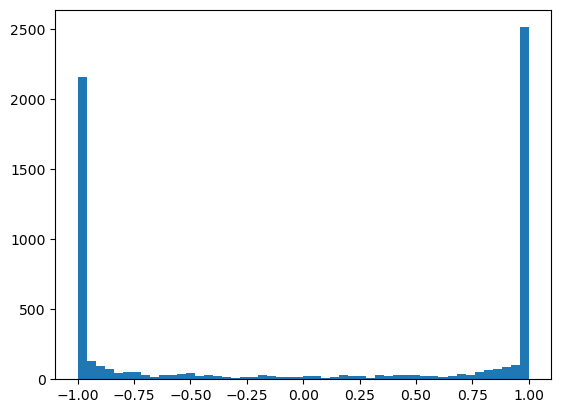

In [51]:
plt.hist(h.view(-1).tolist(), 50);

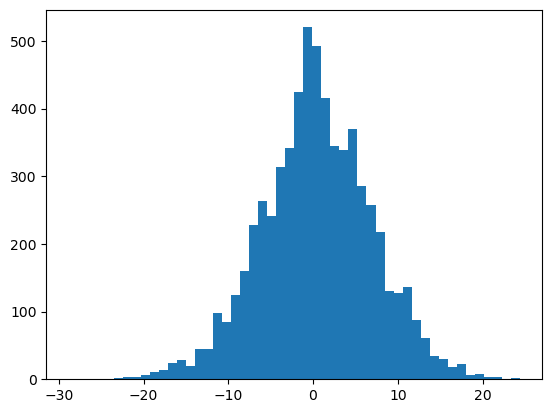

In [52]:
plt.hist(hpreact.view(-1).tolist(), 50);

In [28]:
# we shouldn't get 27 as the loss initially
# prob dist at init should be uniform, assigning equal prob to all chars
# so prob for one char is 1/27
# we want logits to be equal at init (all zeros)
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [29]:
# save the params
state_dict = {
    'C': C,
    'W1': W1,
    'W2': W2,
    'b1': b1,
    'b2': b2
}

torch.save(state_dict, 'model_state.pt')

In [30]:
# load params
loaded_state = torch.load('model_state.pt')
C = loaded_state['C']
W1 = loaded_state['W1']
W2 = loaded_state['W2']
b1 = loaded_state['b1']
b2 = loaded_state['b2']

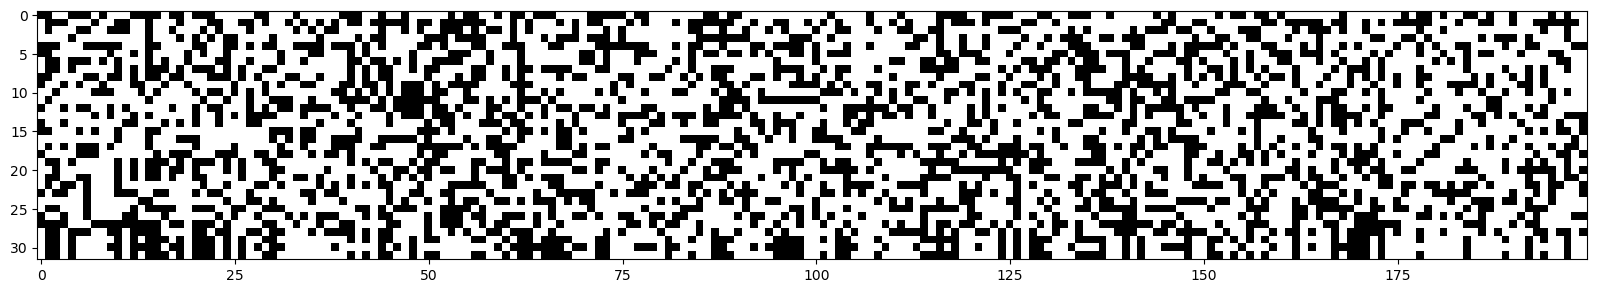

In [31]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

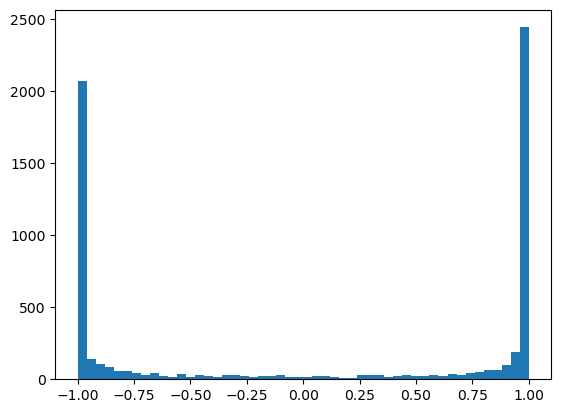

In [32]:
plt.hist(h.view(-1).tolist(), 50);

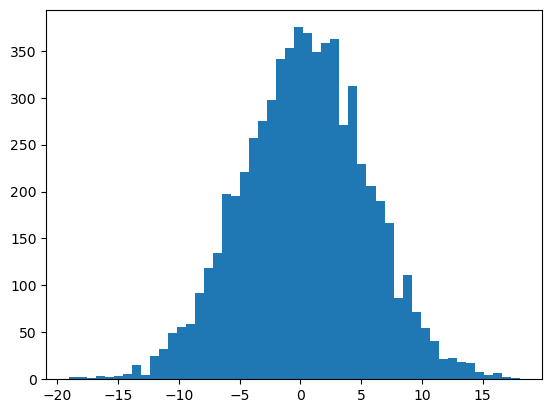

In [33]:
plt.hist(hpreact.view(-1).tolist(), 50);

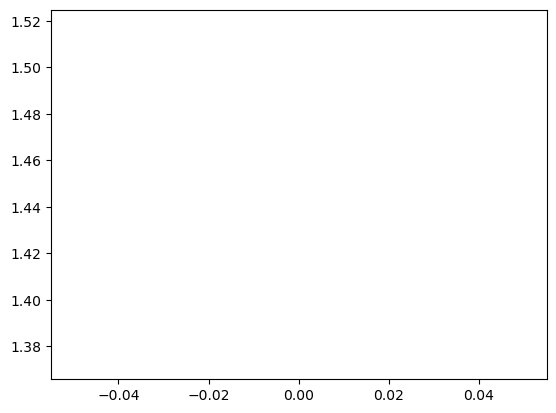

In [34]:
plt.plot(lossi)

In [35]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)


In [36]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1  + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 25.167741775512695
val 25.140993118286133


In [37]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 11)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

rrnhvqbgcdyhdyrzgthxjyrnnxvymhjryhcyysewylsonhodydiediediddaddrwuwddsewylsovyyhdyrzgthxjyrhguyozvwthsjkhgkbdnrzccvnhguyozvwucoyhshflkrqnslkdaadjdyhddrshvyycovwixtyxfvwthsewgmtiofvwths.
rrqwaejqhgcbyhidikdixjyrhguyozvwucovwidikdixjyrnnxvkhhoyyyrzucovwthslrhcgfccyvyhvkrhndiejoyhshodydiejoyhvkrhndiedaejkyicbesrrmhokyyndulhoewidtesjrhgtfxjkcyqcbesrrmhotyxfvwovsmcjrkhojyigddrzvwucovwthslrhcgfyyoadiddxshvyyhjkdixjyhguyozvwuhjryhcyyshvyyhodydiediddadiddadiddadiddxshvyyhjkdgxheoyhshwjwthsjkhgkbynrrhwvkhhjryhcyyshvyyhadiddadiddxshvyyhodydiedixjyrnnxvymhjryhcyyshvyicbesrrmhokwdnsjq.
hvcyhguyozvwthslrhcgfccyvyhcyysovyyhjkdixjyrnnxvymhjzigkoyndulhdyrzgthxjy.
.
.
.
.
rrnhodydiediejoyhshvyyhjktixjyrnnxvymhjryhcyysewgmtiofvwothslrjkhgkbdnejkyoaddrzvwthslrhndiediediddadiddadiddxshvyyhjkrhndrewaesyxshvyyhjkdixjyrhguyozvwucovwidtesjrhguyozvwucovwidtesjrhguyozvyyhjkdgxvnthxjyrnuovwthslrhcgfccamhjziyrzgthxjyrnnxvymhjzigkyojvyhcyysewgmtiofvyrhgdfsnxshvyycoewiekkoon.
.
.
rrnhvqbgxdyrzgthxjyrnnxvymhjkdixjyrh

## 18:20